# Clasificación de dígitos — apuntes impersonales

Notas rápidas: objetivo y contexto
- Objetivo: clasificar dígitos escritos a mano del dataset MNIST usando una CNN sencilla.
- Tipo de problema: clasificación de imágenes (10 clases, dígitos 0–9).
- Enfoque: pipeline típico → carga de datos, preprocesamiento, modelo, entrenamiento, evaluación y prueba con imagen externa.

## MNIST Dataset
Dataset MNIST — notas:
- Contiene imágenes 8×8 en escala de grises de dígitos (0–9).
- Se cargará con `sklearn.datasets.load_digits()` para simplificar el flujo.

In [95]:
from tabnanny import verbose

from sklearn.datasets import load_digits

digits = load_digits()


In [96]:
digits.keys()


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [97]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 1797
:Number of Attributes: 64
:Attribute Information: 8x8 image of integer pixels in the range 0..16.
:Missing Attribute Values: None
:Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
:Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an in

## Visualización de una imagen
Nota: fijar un índice para inspeccionar una imagen de ejemplo y su etiqueta asociada.

In [98]:
index = 0


In [99]:
image = digits.images[index]
label = digits.target[index]


In [100]:
print(image)


[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


In [101]:
image.shape

(8, 8)

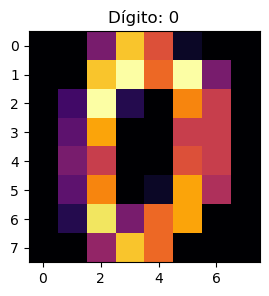

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
plt.imshow(image, cmap=plt.cm.inferno)
plt.title(f'Dígito: {label}')
plt.show()


## Preprocesamiento de datos
Partición de datos — notas:
- Split train/test 80/20 con `train_test_split`.
- Etiquetas a one-hot con `to_categorical` (10 clases).

In [103]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target,
    test_size=0.2, random_state=42
)

# One-hot encode the target variable
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


Tamaños de conjuntos — nota:
- Verificar dimensiones de `X_train` y `X_test` para confirmar el split.

In [104]:
print(X_train.shape)
print(X_test.shape)


(1437, 64)
(360, 64)


Inspección rápida de un ejemplo en `X_train` (post-split):

In [105]:
reshaped_tensor = tf.reshape(X_train[0], shape=(8, 8)) # Redimensionar a 8x8
print(reshaped_tensor)


tf.Tensor(
[[ 0.  0.  3. 14.  1.  0.  0.  0.]
 [ 0.  0. 12. 12.  0.  0.  0.  0.]
 [ 0.  3. 16.  6.  0.  0.  0.  0.]
 [ 0.  5. 16.  2.  0.  0.  0.  0.]
 [ 0.  6. 16.  2.  5.  2.  0.  0.]
 [ 0.  4. 16.  2. 12. 15.  2.  0.]
 [ 0.  1. 14. 13.  2. 13. 11.  0.]
 [ 0.  0.  3. 11. 16. 13.  4.  0.]], shape=(8, 8), dtype=float64)


In [106]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Notas sobre escalado (impersonal):
- StandardScaler → centra en 0 y ajusta a varianza 1 (útil cuando las variables tienen distintas escalas/distribuciones).
- MinMaxScaler → reescala a un rango (común: 0–1) cuando se requiere un intervalo fijo o el algoritmo es sensible a la escala.
- Objetivo del escalado: estabilizar el entrenamiento y mejorar el rendimiento de modelos sensibles a la magnitud de las características.

Ahora notamos como se ve el primer elemento de la variable X_train después de la normalización

In [107]:
reshaped_tensor = tf.reshape(X_train[0], shape=(8, 8))
# Redondeamos para tener una mejor visualizacion
reshaped_tensor =  tf.floor(reshaped_tensor * 100) / 100
print(reshaped_tensor)

tf.Tensor(
[[ 0.   -0.35 -0.47  0.5  -2.55 -1.04 -0.41 -0.14]
 [-0.07 -0.62  0.3   0.   -2.19 -1.36 -0.53 -0.14]
 [-0.05  0.12  1.08 -0.2  -1.17 -1.28 -0.56 -0.12]
 [-0.04  0.86  1.13 -1.17 -1.61 -1.29 -0.63 -0.05]
 [ 0.    1.09  1.34 -1.13 -0.91 -1.14 -0.82  0.  ]
 [-0.07  0.82  1.39 -0.83  0.69  1.17 -0.34 -0.1 ]
 [-0.04  0.15  1.14  0.64 -1.43  0.68  1.47 -0.22]
 [-0.03 -0.31 -0.5  -0.25  0.84  1.05  0.45 -0.2 ]], shape=(8, 8), dtype=float64)


In [108]:
# Redimensionar el tensor a la forma (total, 8, 8)
X_train = tf.reshape(X_train, (X_train.shape[0], 8, 8))
X_test = tf.reshape(X_test, (X_test.shape[0], 8, 8))

In [109]:
X_train[0]

<tf.Tensor: shape=(8, 8), dtype=float64, numpy=
array([[ 0.        , -0.34169755, -0.46336049,  0.50836462, -2.54590607,
        -1.03722581, -0.40623424, -0.13101874],
       [-0.06103492, -0.61725402,  0.30881425,  0.00348328, -2.18152552,
        -1.35608548, -0.52465505, -0.13336005],
       [-0.04991522,  0.12851911,  1.08857992, -0.19343737, -1.16010978,
        -1.27307852, -0.552537  , -0.11409248],
       [-0.03733267,  0.86365151,  1.13744682, -1.16195968, -1.60835913,
        -1.28296188, -0.62554872, -0.04573894],
       [ 0.        ,  1.09151514,  1.34318585, -1.12678131, -0.90106555,
        -1.13185292, -0.81347241,  0.        ],
       [-0.06519029,  0.82828946,  1.39981472, -0.82540858,  0.69177178,
         1.17865528, -0.33784246, -0.09403434],
       [-0.03963009,  0.15955797,  1.14244768,  0.64507954, -1.42282149,
         0.68917912,  1.47990131, -0.21608405],
       [-0.02638899, -0.30677646, -0.49962244, -0.246272  ,  0.84804385,
         1.05270303,  0.45952251

## Red neuronal convolucional

In [110]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

# Crear el modelo de CNN
model = Sequential([
    Conv2D(32, kernel_size=(3, 3),
        activation='relu',
        input_shape=(8, 8, 1)
    ),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

/home/nictez/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Notas del modelo (secuencial Keras):
- Conv2D(32, kernel 3×3, ReLU) sobre entradas 8×8×1.
- MaxPooling2D(2×2) para reducir dimensión espacial.
- Flatten para pasar a densas.
- Dense(128, ReLU) → Dense(10, Softmax) para probabilidades por clase.

## Compilar el modelo
Crear un optimizador Adam con una tasa de aprendizaje del 0.001

In [111]:
from tensorflow.keras.optimizers import Adam

# Tasa de aprendizaje deseada
learning_rate = 0.001
adam_optimizer = Adam(learning_rate=learning_rate)

In [112]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Notas de compilación:
- Optimizador: Adam (se puede pasar como string `'adam'` o instancia `Adam(learning_rate=...)`).
- Pérdida: `categorical_crossentropy` (etiquetas en one-hot).
- Métrica principal: `accuracy`.

## Entrenar el modelo

In [113]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=2
)

Epoch 1/10
36/36 - 2s - 47ms/step - accuracy: 0.6806 - loss: 1.5297 - val_accuracy: 0.8472 - val_loss: 0.8177
Epoch 2/10
36/36 - 0s - 5ms/step - accuracy: 0.9217 - loss: 0.4815 - val_accuracy: 0.9132 - val_loss: 0.3353
Epoch 3/10
36/36 - 0s - 6ms/step - accuracy: 0.9539 - loss: 0.2260 - val_accuracy: 0.9340 - val_loss: 0.2371
Epoch 4/10
36/36 - 0s - 5ms/step - accuracy: 0.9687 - loss: 0.1475 - val_accuracy: 0.9514 - val_loss: 0.1671
Epoch 5/10
36/36 - 0s - 5ms/step - accuracy: 0.9782 - loss: 0.1094 - val_accuracy: 0.9549 - val_loss: 0.1577
Epoch 6/10
36/36 - 0s - 5ms/step - accuracy: 0.9861 - loss: 0.0838 - val_accuracy: 0.9514 - val_loss: 0.1287
Epoch 7/10
36/36 - 0s - 5ms/step - accuracy: 0.9896 - loss: 0.0637 - val_accuracy: 0.9653 - val_loss: 0.1112
Epoch 8/10
36/36 - 0s - 5ms/step - accuracy: 0.9913 - loss: 0.0550 - val_accuracy: 0.9583 - val_loss: 0.1066
Epoch 9/10
36/36 - 0s - 7ms/step - accuracy: 0.9956 - loss: 0.0422 - val_accuracy: 0.9618 - val_loss: 0.1009
Epoch 10/10
36/36 

Notas de entrenamiento:
- `model.fit(...)` con `epochs`, `batch_size` y `validation_split` para monitorear desempeño.
- `verbose=2` para salida compacta por época.

## Función de pérdida

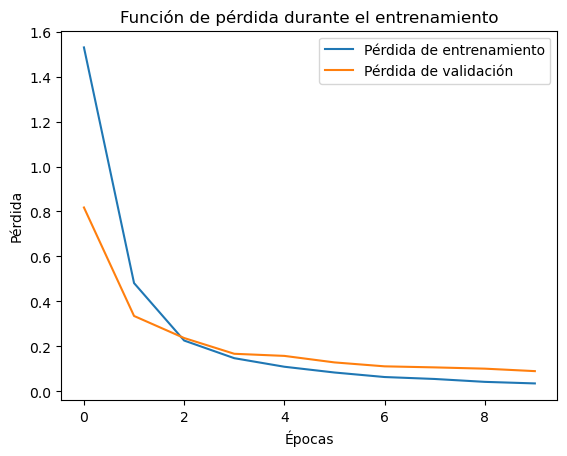

In [114]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Función de pérdida durante el entrenamiento')
plt.show()


Nota rápida: la pérdida debería decrecer (idealmente acercarse a 0) si el modelo aprende adecuadamente; vigilar también `val_loss` para detectar sobreajuste.

## Evaluación
Notas de evaluación:
- Evaluar en el conjunto de prueba para obtener `loss` y `accuracy` finales.

In [115]:
loss, accuracy = model.evaluate(X_test, y_test, verbose = 2)
print(f'Loss: {loss}, Accuracy: {accuracy}')

12/12 - 0s - 20ms/step - accuracy: 0.9778 - loss: 0.0650
Loss: 0.06502095609903336, Accuracy: 0.9777777791023254


Notas:
- `model.evaluate` devuelve pérdida y precisión sobre el conjunto de prueba.
- Útil para comparar con validación y monitorear posible sobreajuste.

## Matriz de confusión y la sensibilidad (recall)

In [116]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
# Convert y_test back to multiclass format
y_test_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
sensitivity = recall_score(y_test_classes, y_pred_classes, average=None)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Notas (predicción y métricas por clase):
- `model.predict` → probabilidades por clase; `argmax` para clases predichas.
- `confusion_matrix(y_true, y_pred)` para errores/aciertos por clase.
- `recall_score(..., average=None)` para sensibilidad por clase.

## Visualización: matriz de confusión y sensibilidad

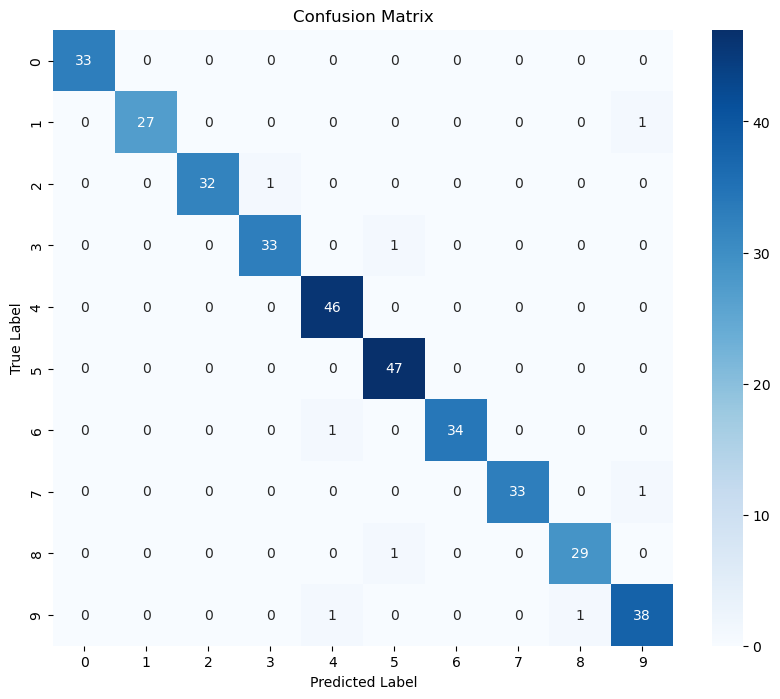

Sensitivity (Recall) for each class:
Class 0: 1.0
Class 1: 0.9642857142857143
Class 2: 0.9696969696969697
Class 3: 0.9705882352941176
Class 4: 1.0
Class 5: 1.0
Class 6: 0.9714285714285714
Class 7: 0.9705882352941176
Class 8: 0.9666666666666667
Class 9: 0.95


In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizar la matriz de confusión como una imagen de colores
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Mostrar la sensibilidad (recall) para cada clase
print('Sensitivity (Recall) for each class:')
for i in range(10):
    print(f'Class {i}: {sensitivity[i]}')

Notas de visualización:
- `sns.heatmap(conf_matrix, ...)` para ver aciertos/errores por clase.
- Imprimir `recall` por clase para detectar clases débiles.

El recall mide la proporción de instancias positivas que fueron correctamente identificadas por el modelo sobre el total de instancias positivas en el conjunto de datos. En otras palabras, el recall indica qué tan efectivo es el modelo para encontrar todas las instancias positivas en comparación con el total de instancias positivas reales en el conjunto de datos.

* Un recall de 1.0 (100%) significa que el modelo identifica todas las instancias positivas correctamente, es decir, no hay falsos negativos.

* Un recall de 0.0 (0%) indica que el modelo no identifica ninguna instancia positiva correctamente, es decir, todos los casos positivos son clasificados como negativos (falsos negativos).

## Bonus (Predecir una imagen distinta al conjunto de datos)

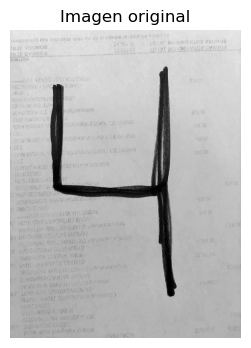

In [118]:
from PIL import Image
import matplotlib.pyplot as plt

# Cambia por el nombre de tu archivo
ruta = "/home/nictez/PycharmProjects/IA/Convolucionales/mi_numero.png"
# Escala de grises ("L")
img = Image.open(ruta).convert("L")

# mostrar la imagen
plt.figure(figsize=(4, 4))
plt.imshow(img, cmap="gray")
plt.title("Imagen original")
plt.axis("off")
plt.show()


## Redimensionar
Redimensionar la imagen a 8x8 pixeles, sin mantener la proporción

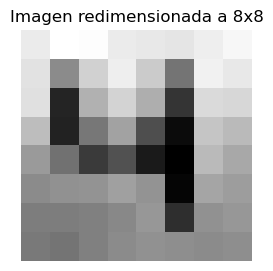

In [119]:
import matplotlib.pyplot as plt

# redimensionar a 8x8
img_resized = img.resize((8, 8), Image.Resampling.LANCZOS)

# mostrar imagen
plt.figure(figsize=(3, 3))
plt.imshow(img_resized, cmap="gray")
plt.title("Imagen redimensionada a 8x8")
plt.axis("off")
plt.show()

# opcional, guardamos la imagen si es necesario
img_resized.save("imagen_8x8.png")


## Preprocesamiento
Se tiene que ajustar la imagen de forma similar a la base de datos utilizada MNIST.

Primero rescalamos los valores de la imagen por los valores utilizados por las imagenes de la base de datos MNIST, es decir, la imagen debe tener valores de entre 0 y 16.

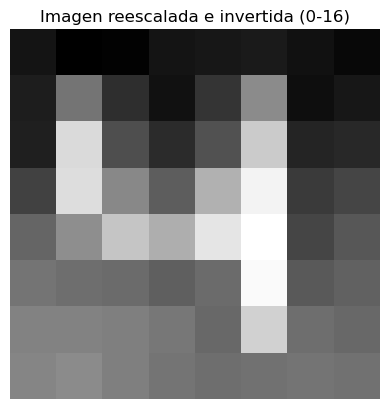

In [120]:
import matplotlib.pyplot as plt
import numpy as np

# reescalar de 0-255 a 0-16 e invertir (fondo negro = 0)
img_array = np.array(img_resized).astype("float32")
img_array = 16 - (img_array / 255 * 16)

# mostrar imagen
plt.imshow(img_array, cmap="gray")
plt.title("Imagen reescalada e invertida (0-16)")
plt.axis("off")
plt.show()


Ahora debe estandarizar la imagen

In [121]:
from sklearn.preprocessing import StandardScaler

# normalizar
scaler = StandardScaler()
img_flat = img_array
img_scaled = scaler.fit_transform(img_flat)

# Dar forma (1,8,8) que es el input del modelo
img_tensor = img_scaled.reshape(1, 8, 8)

Evaluación

In [122]:
pred = model.predict(img_tensor)
digit = np.argmax(pred)
print("Predicción:", digit)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicción: 4
